In [748]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import Dense
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

In [749]:
listings_df = pd.read_csv('../data/processed/processed_listings.csv').dropna()
len(listings_df)

62404

In [750]:
listings_df.head()

,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_year,listing_date,year_of_construction,price
0,2 Storey,2 storey,1191,4076,3,1,2,Beauport,2020,2020-12-01,2004,332500
1,Bungalow,Open area,1261,9500,2,1,1,Deschambault,2021,2021-12-01,1957,265000
2,Townhouse,Unknown,1645,1360,3,1,3,Mercier,2021,2021-11-01,2006,612000
3,Bi-generation,Link,2024,17000,4,3,1,Stoneham,2021,2021-12-01,2019,526500
4,Semi-detached,2 storey,2400,4471,4,2,2,Gatineau,2021,2021-12-01,1989,360000


## Correlation Heat Map

In [751]:
sns.set_theme(style="white")

def plot_corr_map(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(8, 6))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

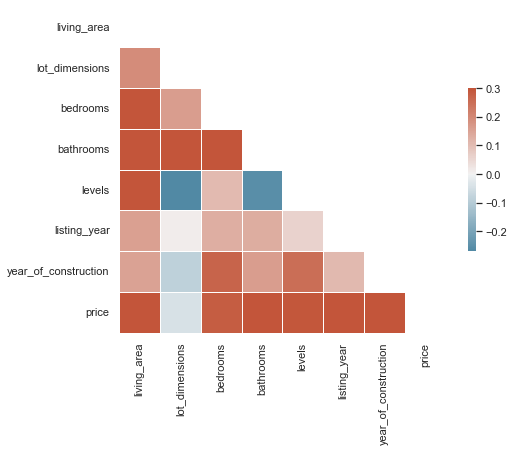

In [752]:
plot_corr_map(listings_df)

## Choosing columns

In [753]:
ordinal_cols = ['location', 'listing_year', 'subtype', 'bedrooms', 'bathrooms']
one_hot_cols = []
numerical_cols = ['living_area', 'year_of_construction']
target_col = ['price']

In [754]:
listings_df = listings_df[ordinal_cols + one_hot_cols + numerical_cols + target_col]
listings_df.head()

,location,listing_year,subtype,bedrooms,bathrooms,living_area,year_of_construction,price
0,Beauport,2020,2 Storey,3,1,1191,2004,332500
1,Deschambault,2021,Bungalow,2,1,1261,1957,265000
2,Mercier,2021,Townhouse,3,1,1645,2006,612000
3,Stoneham,2021,Bi-generation,4,3,2024,2019,526500
4,Gatineau,2021,Semi-detached,4,2,2400,1989,360000


## One Hot Encoding

In [755]:
def oh_encode(df_line, col, new_col, val):
    if df_line[col] == val:
        return df_line[new_col] + 1
    else:
        return df_line[new_col]

for col in one_hot_cols:
    for val in listings_df[col].unique():   
        new_col = str(val) + '_' + col
        listings_df[new_col] = 0
        listings_df[new_col] = listings_df.apply(oh_encode, args=(col, new_col, val), axis=1)

    listings_df = listings_df.drop(columns=[col])

In [756]:
listings_df.head()

,location,listing_year,subtype,bedrooms,bathrooms,living_area,year_of_construction,price
0,Beauport,2020,2 Storey,3,1,1191,2004,332500
1,Deschambault,2021,Bungalow,2,1,1261,1957,265000
2,Mercier,2021,Townhouse,3,1,1645,2006,612000
3,Stoneham,2021,Bi-generation,4,3,2024,2019,526500
4,Gatineau,2021,Semi-detached,4,2,2400,1989,360000


## Spliting Data

In [757]:
y = listings_df[target_col]
X = listings_df.drop(columns=target_col)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

## Ordinal Encoding

In [758]:
ordinal_encoders = {}

for col in ordinal_cols:
    ordinal_encoders[col] = OrdinalEncoder()
    X_train[col] = ordinal_encoders[col].fit_transform(X_train[[col]])
    X_test[col] = ordinal_encoders[col].transform(X_test[[col]])

X_train.head()

,location,listing_year,subtype,bedrooms,bathrooms,living_area,year_of_construction
13885,8.0,13.0,6.0,2.0,0.0,1537,2006
57173,7.0,18.0,3.0,2.0,1.0,960,1989
4743,18.0,17.0,3.0,3.0,1.0,1648,1967
11301,24.0,14.0,6.0,2.0,0.0,782,1993
13033,11.0,13.0,1.0,2.0,0.0,1651,2012


## Scaling

In [759]:
scaled_cols = numerical_cols + ordinal_cols

In [760]:
scalers = {}

for col in scaled_cols:
    scalers[col] = MinMaxScaler()
    X_train[col] = scalers[col].fit_transform(X_train[[col]])
    X_test[col] = scalers[col].transform(X_test[[col]])

In [761]:
scale_target = True

if scale_target:
    target_scaler = MinMaxScaler()

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.fit_transform(y_test)

X_train.head()

,location,listing_year,subtype,bedrooms,bathrooms,living_area,year_of_construction
13885,0.333333,0.722222,0.750,0.4,0.000000,0.298900,0.948980
57173,0.291667,1.000000,0.375,0.4,0.333333,0.131944,0.891156
4743,0.750000,0.944444,0.375,0.6,0.333333,0.331019,0.816327
11301,1.000000,0.777778,0.750,0.4,0.000000,0.080440,0.904762
13033,0.458333,0.722222,0.125,0.4,0.000000,0.331887,0.969388


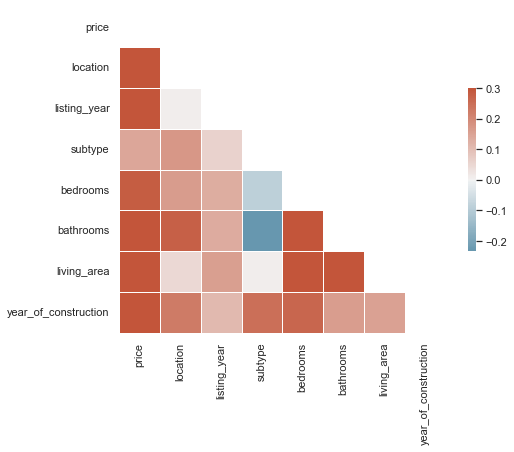

In [762]:
df = X_train.copy()
df.insert(0, 'price', y_train)
plot_corr_map(df)

In [763]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.3668366415873674

# Neural Net

In [764]:
model = Sequential()
model.add(Dense(units=25, activation='sigmoid', input_shape=(X_train.shape[-1],)))
model.add(Dense(units=10, activation='sigmoid'))
model.add(Dense(units=5, activation='sigmoid'))
model.add(Dense(units=1, activation='linear'))

print(model.summary())

model.compile(optimizer=Adam(lr=0.001), loss='mse')

history = model.fit(X_train, y_train, batch_size=1000, epochs=500, shuffle=True, verbose=1, validation_data=(X_test, y_test))

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 25)                200       
                                                                 
 dense_89 (Dense)            (None, 10)                260       
                                                                 
 dense_90 (Dense)            (None, 5)                 55        
                                                                 
 dense_91 (Dense)            (None, 1)                 6         
                                                                 
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


44/44 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0225
Epoch 2/500
44/44 [==============================] - 0s 1ms/step - loss: 0.0225 - val_loss: 0.0252
Epoch 3/500
44/44 [==============================] - 0s 1ms/step - loss: 0.0220 - val_loss: 0.0244
Epoch 4/500
44/44 [==============================] - 0s 1ms/step - loss: 0.0219 - val_loss: 0.0244
Epoch 5/500
44/44 [==============================] - 0s 1ms/step - loss: 0.0218 - val_loss: 0.0243
Epoch 6/500
44/44 [==============================] - 0s 1ms/step - loss: 0.0217 - val_loss: 0.0241
Epoch 7/500
44/44 [==============================] - 0s 1ms/step - loss: 0.0216 - val_loss: 0.0241
Epoch 8/500
44/44 [==============================] - 0s 1ms/step - loss: 0.0215 - val_loss: 0.0239
Epoch 9/500
44/44 [==============================] - 0s 1ms/step - loss: 0.0213 - val_loss: 0.0237
Epoch 10/500
44/44 [==============================] - 0s 1ms/step - loss: 0.0212 - val_loss: 0.0235
Epoch 11/500
44/44 [=

In [765]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

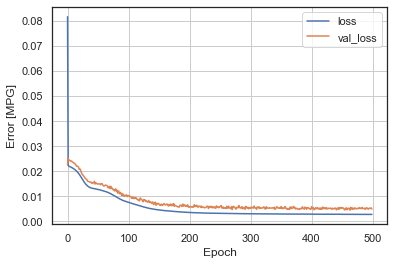

In [766]:
plot_loss(history)

In [767]:
sk_predicted_prices = target_scaler.inverse_transform(reg.predict(X_test))
nnet_predicted_prices = target_scaler.inverse_transform(model.predict(X_test))
real_prices = target_scaler.inverse_transform(y_test)

In [768]:
test_df = X_test.copy()

In [769]:
for col in scaled_cols:
    test_df[col] = scalers[col].inverse_transform(test_df[[col]])

for col in ordinal_cols:
    test_df[col] = ordinal_encoders[col].inverse_transform(test_df[[col]])

In [770]:
d = {}
d['real price'] = list(real_prices)
d['nnet predicted price'] = list(nnet_predicted_prices)
d['sk predicted price'] = list(sk_predicted_prices)

test_df['real price'] = d['real price']
test_df['nnet predicted price'] = d['nnet predicted price']
test_df['sk predicted price'] = d['sk predicted price']

test_df['real price'] = test_df['real price'].astype(int)
test_df['nnet predicted price'] = test_df['nnet predicted price'].astype(int)
test_df['sk predicted price'] = test_df['sk predicted price'].astype(int)

In [771]:
test_df.head(12)

,location,listing_year,subtype,bedrooms,bathrooms,living_area,year_of_construction,real price,nnet predicted price,sk predicted price
22815,Beauport,2011,Semi-detached,4,1,1320.0,2003.0,228000,267623,235555
37440,Mercier,2021,Townhouse,3,1,1645.0,2006.0,612000,642507,476259
40596,St-Raymond,2021,Semi-detached,4,1,881.0,2018.0,242500,286930,476667
25514,Longueuil,2007,Semi-detached,4,1,1872.0,1986.0,192000,268329,231777
47402,Gatineau,2021,Semi-detached,4,2,2400.0,1989.0,360000,402438,493339
19818,Trois-Rivières,2012,2 Storey,4,1,1850.0,1947.0,250000,315314,307000
40690,Mercier,2021,Townhouse,3,1,1645.0,2006.0,612000,642507,476259
6195,St-Jérôme,2019,2 Storey,3,1,1646.0,1989.0,418000,382763,424150
17893,Sherbrooke,2014,2 Storey,5,1,1750.0,2009.0,330000,388736,371514
44963,Alma,2021,2 Storey,5,2,1800.0,1989.0,284000,334712,407615


In [772]:
errors = abs(nnet_predicted_prices - real_prices)
errors_small = list(filter(lambda x: x < 100000, errors))
errors_pct = 100 * (abs(nnet_predicted_prices - real_prices) / real_prices)
errors_pct_small = list(filter(lambda x: x < 100, errors_pct))

c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

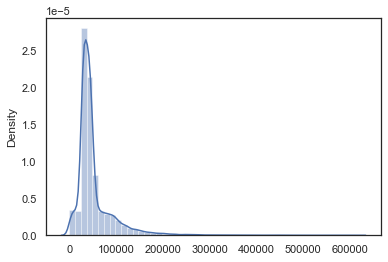

In [773]:
sns.distplot(errors)

c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

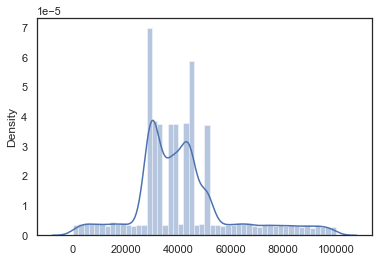

In [774]:
sns.distplot(errors_small)

c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

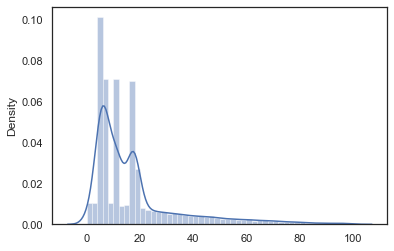

In [775]:
sns.distplot(errors_pct_small)

In [776]:
e_avg = int(np.mean(errors))
e_std = int(np.std(errors))
epct_avg = round(np.mean(errors_pct), 2)
epct_std = round(np.std(errors_pct), 2)

print('Error Mean ($): ' + str(e_avg) + '$')
print('Error std ($): ' + str(e_std) + '$')
print('Error Mean (%): ' + str(epct_avg) + '%')
print('Error std (%): ' + str(epct_std) + '%')

Error Mean ($): 51743$
Error std ($): 40234$
Error Mean (%): 18.79%
Error std (%): 21.52%
